In [1]:
from keras.utils import normalize
from unet_model import multi_unet_model
from unet512 import unet
import os
import glob
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

2024-11-29 18:14:39.188969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 18:14:39.302525: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 18:14:39.348355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 18:14:39.657388: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Define constants
SIZE_X = 256 
SIZE_Y = 256
n_classes = 8  # Number of classes for segmentation

# Capture training image info as a list
train_images = []
for directory_path in glob.glob("/home/abdulrauf/Projects/MakhiMeter-Training/data/training/model_v1.2/experiment_2/without_rotation/size 256/augmented rgb 256/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)  # Read as grayscale
        train_images.append(img)
        
# Convert list to array for machine learning processing
train_images = np.array(train_images)

# Capture mask/label info as a list
train_masks = []
for directory_path in glob.glob("data/training/model_v1.2/experiment_2/without_rotation/size 256/augmented masked 256/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)  # Read mask as grayscale
        train_masks.append(mask)
        
# Convert list to array for machine learning processing
train_masks = np.array(train_masks)

In [ ]:
# n, h, w = train_masks.shape  # Get shape of the mask data
# train_masks_reshaped = train_masks.reshape(-1, 1)  # Flatten the mask to a 2D array

# # Initialize and apply label encoder
# labelencoder = LabelEncoder()

# # Fit label encoder and transform mask values to sequential integers
# train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)

# # Reshape back to the original mask shape
# train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

# # Check unique labels
# unique_labels = np.unique(train_masks_encoded_original_shape)
# print("Unique labels in the encoded mask:", unique_labels)

# # Print the mapping of original pixel values to encoded labels
# print("Label mapping:")
# for original, encoded in zip(labelencoder.classes_, range(len(labelencoder.classes_))):
#     print(f"Original value {original} -> Encoded label {encoded}")
batch_size = 32

train_images = np.expand_dims(train_images, axis=3)
for i in range(0, len(train_images), batch_size):
    train_images[i:i+batch_size] = train_images[i:i+batch_size] / 255.0

train_images = normalize(train_images, axis=1)

# train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [3]:
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [  0  43  54  76 105 149 178 225]


MemoryError: Unable to allocate 26.1 GiB for an array with shape (437780480, 8) and data type float64

In [ ]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_masks_reshaped_encoded),
#                                                  train_masks_reshaped_encoded)
# print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

def get_model2():
    return unet(n_class=n_classes, input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

model = get_model2()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')



NameError: name 'n_classes' is not defined

In [6]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    


# model.save('test.hdf5')

Epoch 1/50


I0000 00:00:1729883130.675206    5354 service.cc:146] XLA service 0x79de1808ace0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729883130.675234    5354 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-10-26 00:05:30.961666: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-26 00:05:32.323238: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-26 00:06:02.927594: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_13', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Reg

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.7064 - loss: 0.8388

2024-10-26 00:06:33.404743: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_13', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_14', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in funct

43/43 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.7079 - loss: 0.8343 - val_accuracy: 0.6959 - val_loss: 1.5917
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 359ms/step - accuracy: 0.8389 - loss: 0.4343 - val_accuracy: 0.2805 - val_loss: 2.7770
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 479ms/step - accuracy: 0.8889 - loss: 0.3001 - val_accuracy: 0.4327 - val_loss: 2.1149
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 571ms/step - accuracy: 0.9323 - loss: 0.1948 - val_accuracy: 0.7390 - val_loss: 2.6796
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 569ms/step - accuracy: 0.9391 - loss: 0.1761 - val_accuracy: 0.7197 - val_loss: 5.5099
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 567ms/step - accuracy: 0.9517 - loss: 0.1357 - val_accuracy: 0.6820 - val_loss: 5.0682
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 574ms/step - accuracy: 0.9573 - loss: 0.1188 - val_accuracy: 0.6992 - val_loss: 5.2784
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 576ms/step - accuracy: 0.9628 - loss: 0.1013 - val_accuracy: 0.7386 -

In [7]:
model.save('models/unet512_256_256_combined_7_classes_50epochs_9832acc_1.2.hdf5')

In [9]:
# AFTER TRAINING

(256, 256, 1)
(1, 256, 256, 1)


/home/abdulrauf/Projects/anaconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_329']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step


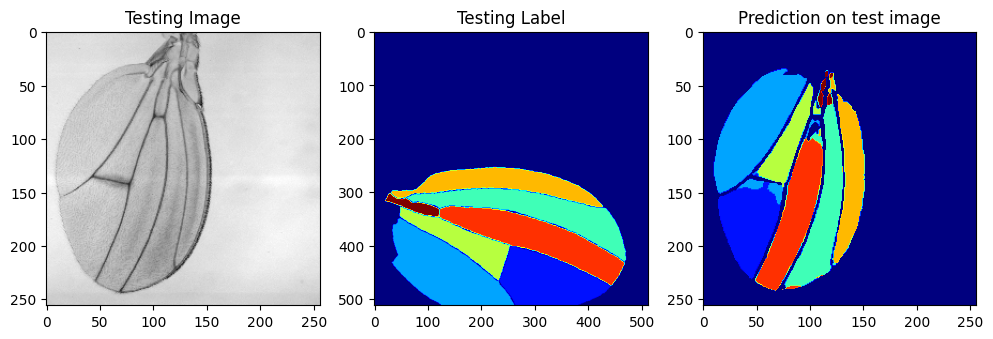

In [10]:

def get_model2():
    return unet(n_class=8, input_size=(256, 256, 1))

def get_model():
    return multi_unet_model()
model = get_model()

model.load_weights('models/version 1.1/unet_256_interpolated_6900_10epochs.h5')  
import random
# print(X_test)
# test_img_number = random.randint(0, len(X_test))
# test_img = X_test[test_img_number]
test_img = cv2.imread('/home/abdulrauf/Projects/MakhiMeter-Training/testing_256.png', 0)
test_img = np.array(test_img)
test_img = normalize(test_img, axis=1)
test_img = np.expand_dims(test_img, axis=-1)
test_img_input = np.expand_dims(test_img, axis=-1)
print(test_img.shape)
ground_truth=cv2.imread('/home/abdulrauf/Projects/MakhiMeter-Training/data/training/model_v1.2/experiment_2/with_rotation/size 512/labeled encoded/rot_90_aug_0_D.annulipes_f_01.png', 0)
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
predicted_img

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:, 0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [92]:
from PIL import Image

output_path = 'predicted_image3.png'
predicted_img_resized = cv2.resize(predicted_img, (720, 480), interpolation=cv2.INTER_NEAREST)

predicted_img_scaled = (predicted_img_resized / predicted_img_resized.max()) * 255  # Scale the prediction to 0-255
predicted_img_scaled = predicted_img_scaled.astype(np.uint8)  # Convert to uint8

# Using PIL to save as grayscale
Image.fromarray(predicted_img_scaled).save(output_path)

In [8]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_layer_1
1 conv2d_19
2 dropout_9
3 conv2d_20
4 max_pooling2d_4
5 conv2d_21
6 dropout_10
7 conv2d_22
8 max_pooling2d_5
9 conv2d_23
10 dropout_11
11 conv2d_24
12 max_pooling2d_6
13 conv2d_25
14 dropout_12
15 conv2d_26
16 max_pooling2d_7
17 conv2d_27
18 dropout_13
19 conv2d_28
20 conv2d_transpose_4
21 concatenate_4
22 conv2d_29
23 dropout_14
24 conv2d_30
25 conv2d_transpose_5
26 concatenate_5
27 conv2d_31
28 dropout_15
29 conv2d_32
30 conv2d_transpose_6
31 concatenate_6
32 conv2d_33
33 dropout_16
34 conv2d_34
35 conv2d_transpose_7
36 concatenate_7
37 conv2d_35
38 dropout_17
39 conv2d_36
40 conv2d_37


In [18]:
from keras.models import Model
layer_outputs = [model.layers[1].output, model.layers[8].output, model.layers[15].output, model.layers[25].output, model.layers[32].output, model.layers[38].output]  # adjust indices based on your model structure
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [19]:
activations = (activation_model.predict(test_img_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


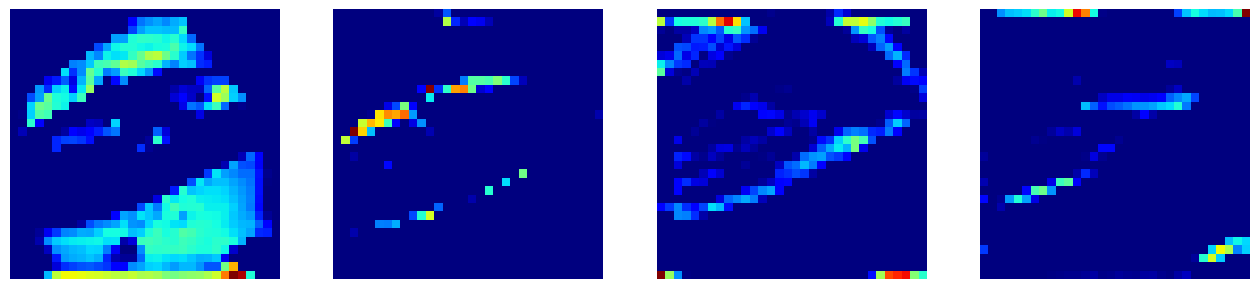

In [37]:
import matplotlib.pyplot as plt

# Choose which layer output you want to visualize
first_layer_activation = activations[2]  # This is the output of the first layer chosen in Step 2

# Let's visualize the first 4 feature maps
plt.figure(figsize=(16, 4))
for i in range(4):  # adjust this to show more or fewer filters
    plt.subplot(1, 4, i + 1)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='jet')
    plt.axis('off')
plt.show()
